<a href="https://colab.research.google.com/github/yenlung/Generative-AI-Book/blob/main/%E5%86%92%E9%9A%AA09_%E6%96%87%E5%AD%97%E7%94%9F%E5%9C%96%E6%A8%A1%E5%9E%8B%E7%9A%84%E9%80%B2%E9%9A%8E%E6%8A%80%E5%B7%A7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

上次的冒險中, 我們介紹用不同版本的 Stable Diffusion 生圖的方法。試玩一陣之後, 你可能發現, 尤其在生照片的時候, 真的是很吃運氣, 常常生不出令人滿意的結果。現在我們來介紹幾個進階技巧, 讓大家更能調整輸出後的結果。

### 1. 安裝必要套件

In [2]:
!pip install transformers
!pip install diffusers["torch"]
!pip install accelerate
!pip install sentencepiece

### 2. 設好我們的 pipeline

如果深入 Stable Diffusion, 還有一個叫做 samplers 的東西。這是 diffusion models 選擇不同 scheduler 運用的 sample 方式。出現的圖會有一些差異, 有些會比較有效率的在比較少的步數完成, 有些需較多步數但有些細緻表現。

這裡我們不特別介紹這些 sampler 有什麼不同, 只給一個指定 sampler 的範例。

In [3]:
import torch

In [4]:
from diffusers import StableDiffusionPipeline, AutoencoderKL, DPMSolverMultistepScheduler

建議開始先用 Stable Diffusion v1.5, 不一定要用我們這裡的, 可以用你當然可以用任何你想用的版本, 比如說:

    prompthero/openjourney-v2
    unwayml/stable-diffusion-v1-5

In [5]:
repo_id = "SG161222/Realistic_Vision_V6.0_B1_noVAE"

In [6]:
pipe = StableDiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


#### 指定 VAE

In [7]:
vae_model = "stabilityai/sd-vae-ft-mse"

In [8]:
vae = AutoencoderKL.from_pretrained(vae_model, torch_dtype=torch.float16).to("cuda")

In [9]:
pipe.vae = vae

#### 指定 Scheduler

可以參考 Hugging Face

[Schedulers](https://huggingface.co/docs/diffusers/v0.26.2/en/api/schedulers/overview#schedulers)

的說明, 注意有些生成時要加入 `use_karras_sigmas=True`。

In [10]:
scheduler = DPMSolverMultistepScheduler.from_config(repo_id,
                                                    subfolder="scheduler")

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


### 3. 把四張圖合併的小函式

我們常常會一次多生幾張圖, 再選喜歡的出來。所以現在先寫四張圖合併顯示的小函式。

In [11]:
from PIL import Image

In [12]:
def combine_imgs(images):
    width, height = images[0].size
    new_img = Image.new('RGB', (width, height))

    w = int(width/2)
    h = int(height/2)

    new_img.paste(images[0].resize((w,h)), (0, 0))
    new_img.paste(images[1].resize((w,h)), (w, 0))
    new_img.paste(images[2].resize((w,h)), (0, h))
    new_img.paste(images[3].resize((w,h)), (w, h))
    return new_img

### 4. 用不同 `prompt` 來測試

PNDMScheduler

生成常用參數:

* **`prompt`**: 咒語
* **`negative_prompt`**: 反向咒語
* **`width`**: 寬 (預設 512)
* **`height`**: 高 (預設 512)
* **`num_images_per_prompt`**: 生幾張圖
* **`num_inference_steps`**: 幾步生成 (預設 50)
* **`guidance_scale`**: GFC scale, 越高越符合 prompt (預設 7.5)
* **`generator`**: 之後控制重點

#### 4-1: steampunk 蒸汽龐克風

In [13]:
prompt = "A digital illustration of a steampunk flying machine in the sky with cogs and mechanisms, 4k, detailed, fantasy vivid colors"

In [16]:
images = pipe(prompt, num_images_per_prompt=4,
              num_inference_steps=31,
              use_karras_sigmas=True).images

  0%|          | 0/31 [00:00<?, ?it/s]

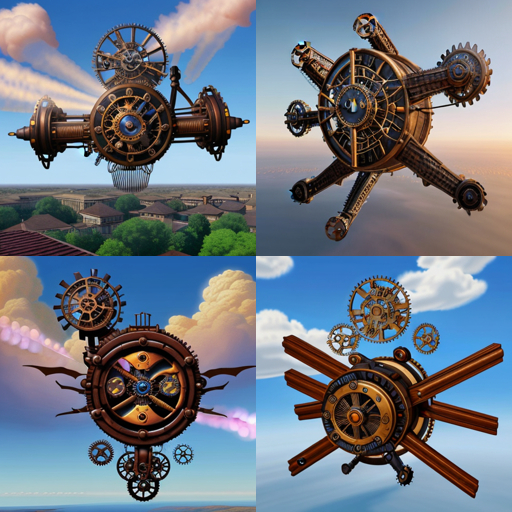

In [17]:
combine_imgs(images)

#### 4-2. flat 2d vector art

In [18]:
prompt = "very cute (owl), simple flat 2d, vector art, minimalist, white background"

In [21]:
images = pipe(prompt, num_images_per_prompt=4,
              num_inference_steps=31,
              use_karras_sigmas=True).images

  0%|          | 0/31 [00:00<?, ?it/s]

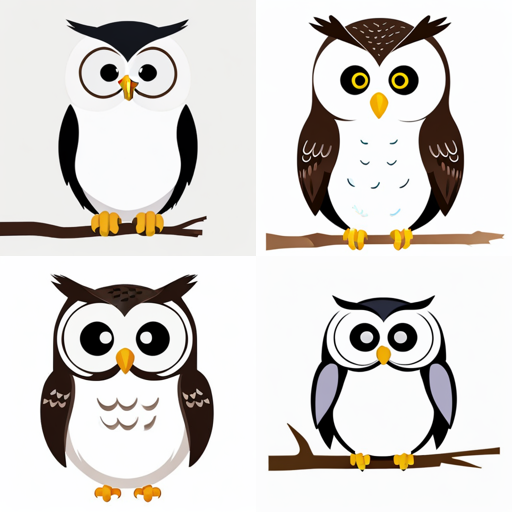

In [22]:
combine_imgs(images)

#### 4-3. icon 設計

In [23]:
prompt = "collection of icon designs for (animals), flat 2d, simple vector art"

In [24]:
images = pipe(prompt, num_images_per_prompt=4,
              num_inference_steps=31,
              use_karras_sigmas=True).images

  0%|          | 0/31 [00:00<?, ?it/s]

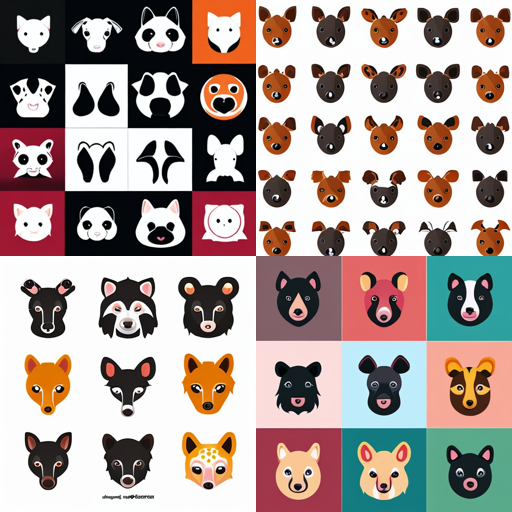

In [26]:
combine_imgs(images)

### 5. 來個有趣的冒險!

政大新生書院曾經辦過由鳥巢老師帶領的 AI 畫圖工作坊, 新生書院的導師立威老師就想了個有趣的方法讓大家試著畫不同的東西。

* **subject 主題**: 小女孩, 某個名人, 貓, 狗等等
* **action 動作**: 看書, 跑步, 騎單車等等
* **style 風格**: 照片, 某位藝術家的風格等等

In [27]:
subject = ['1girl', 'tzuyu chou', 'cat', 'dog', 'pig', 'bird']
action = ['riding a bicycle', 'reading a book', 'running', 'having coffee']
style = ['steampunk', 'van gogh', 'joan miro', 'salvador dali',
         'children book illustration']

In [28]:
prompt_list = []
prompt_list.append(np.random.choice(subject))
prompt_list.append(np.random.choice(action))
prompt_list.append(np.random.choice(style) + " style")

In [29]:
prompt = ', '.join(prompt_list)

In [30]:
prompt

'tzuyu chou, having coffee, salvador dali style'

In [31]:
images = pipe(prompt, num_images_per_prompt=4,
              num_inference_steps=31,
              use_karras_sigmas=True).images

  0%|          | 0/31 [00:00<?, ?it/s]

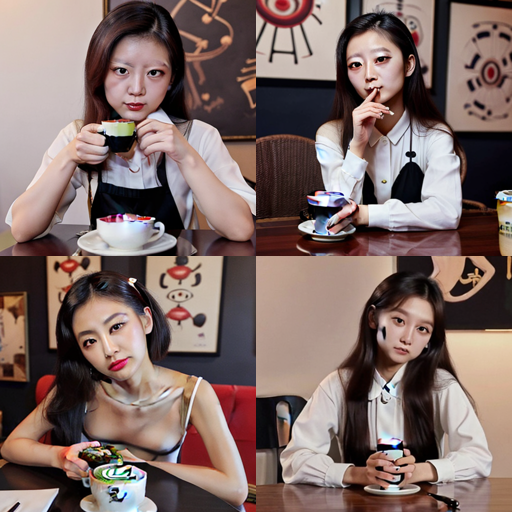

In [32]:
combine_imgs(images)

### 6. 用指定 random seed 生圖

所有的生成模型, 在輸入時會以亂數取得輸入的特徵向量 (或更一般的 tensors)。而電腦的亂數其實是模擬出來, 也就是算出來的, 重點就是亂數種子 random seed, 也就是要指定一個數字。通常亂數種子是由系統時間來的, 每次不同所以會有些變化。但如同其他機器學習的方式一樣, 我們也可以用選定的 random seed, 來做比較好的調校控制。

我們可以電腦自動選 4 個亂數, 產生 4 個用不同 random seed 的 generators。不過這裡為了大家看到一致的結果, 直接指定 4 個數字。

In [33]:
seeds = list(map(int, np.random.randint(0, 100000000, 4)))

In [34]:
seeds

[57042270, 31871551, 95463419, 37802959]

In [35]:
prompt = 'a beautiful taiwanese young woman sitting in a cafe'

In [46]:
generator = [torch.Generator(device="cpu").manual_seed(i) for i in seeds]

In [47]:
images = pipe(prompt, generator=generator,
              num_images_per_prompt=4,
              num_inference_steps=31,
              use_karras_sigmas=True).images

  0%|          | 0/31 [00:00<?, ?it/s]

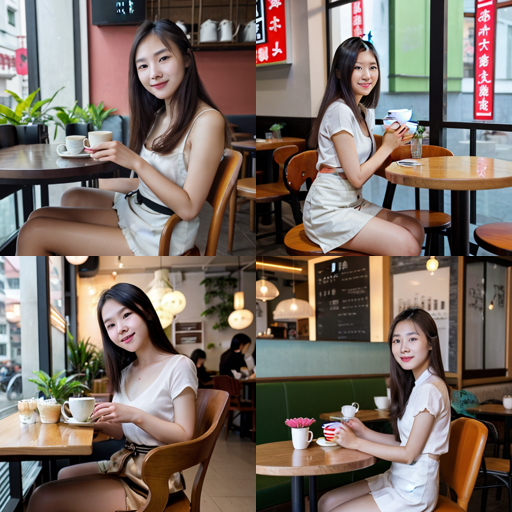

In [48]:
combine_imgs(images)

### 7. 加入負向提示去掉不想要的部份

Stable Diffusion 進階技巧的重點就是 negative prompt。我們這裡用一些常見照片出現的缺點: 人物臉太可怕、變型、多出手或腳、長頸人等等, 告訴模型避免這些。有時模型沒有那麼聽話, 不過通常還是有相當的效果。

    negative_prompt = "ugly, deformed, disfigured, blurry, underage, painting, bad anatomy, long neck, extra arm, extra finger"

In [49]:
negative_prompt = "ugly, paintings, sketches, worst quality, low quality, normal quality, monochrome, duplicate, morbid, mutilated, mutated hands, poorly drawn hands, blurry, bad anatomy, bad proportions, extra limbs, disfigured"

In [56]:
generator = [torch.Generator(device="cpu").manual_seed(i) for i in seeds]

In [57]:
images = pipe(prompt,
              negative_prompt=negative_prompt,
              generator=generator,
              num_images_per_prompt=4,
              num_inference_steps=51,
              use_karras_sigmas=True).images

  0%|          | 0/51 [00:00<?, ?it/s]

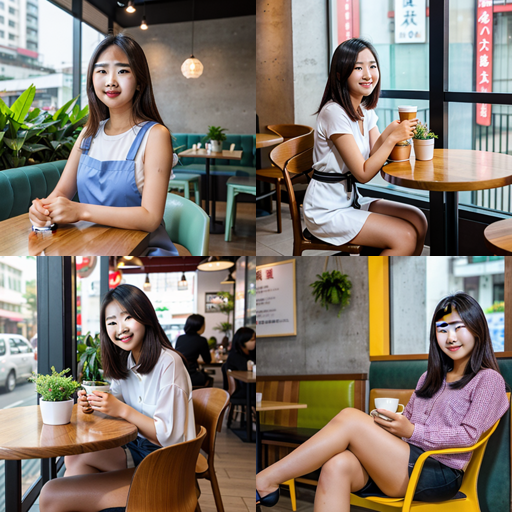

In [58]:
combine_imgs(images)

你會發現加了 negative prompt 之後, 即使是用同樣的 random seed, 還是有相當不同的結果。不過這是因為我們最初沒有動用 negative prompt, 一開始就用，稍稍改變 prompt (或 negative prompt) 會是比較接近的圖。

有時我們會想, 某些 prompt 要修改一下, 但又擔心這麼做原本可能還有點滿意只有點小缺點的圖會不見。現在知道控制好 random seed, 完全可以原圖重現! 因此可以大擔去調整。

### 8. 把特定的圖多算幾次

假如覺得第 4 張是最好的，我們多算幾步, 看可不可以生成較好的圖。

In [62]:
generator = torch.Generator(device="cpu").manual_seed(seeds[3])

In [63]:
image = pipe(prompt,
              negative_prompt=negative_prompt,
              generator=generator,
              num_inference_steps=80,
              use_karras_sigmas=True).images[0]

  0%|          | 0/80 [00:00<?, ?it/s]

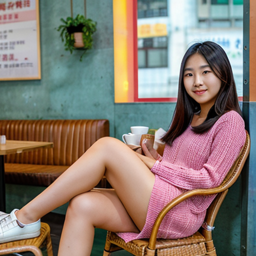

In [64]:
image.resize([256,256])